### This notebook demonstrates how to classify supernovae (e.g., Type Ia vs. non-Ia) using Support Vector Machines (SVM). We'll use a synthetic dataset resembling real supernova light curve features.

### Support Vector Machines (SVM) 
are a powerful supervised learning algorithm widely used for classification tasks, including astronomical applications like supernova classification. 

SVM can be applied to distinguish between different types of supernovae (e.g., Type Ia, Type II, etc.):

### 1. Key Concepts of SVM

Objective: SVM finds the optimal hyperplane (decision boundary) that maximally separates data points of different classes 
in a high-dimensional feature space.
Margin: The distance between the hyperplane and the closest data points (called support vectors). SVM maximizes this margin to 
improve generalization.
Kernel Trick: If data is not linearly separable, SVM uses kernel functions (e.g., Gaussian/RBF, polynomial) to map features into 
a higher-dimensional space where separation is possible.

### 2. SVM for Supernova Classification
Input Features
Supernova light curves and spectra provide features such as:
* Peak brightness (magnitude in different filters, e.g., u, g, r, i, z).
* Decline rates (e.g., Δm₁₅, the change in magnitude 15 days after peak).
* Colors (e.g., g − r, i − z at specific phases).
* Spectral line strengths (e.g., Si II absorption, Hα emission).
* Time-domain features (rise time, duration).

Preprocessing
Standardize/normalize features (SVM is sensitive to scale).
* Handle missing data (imputation or removal).
* Augment data if the sample size is small (e.g., synthetic light curves).

Training the SVM
* Binary Classification (e.g., Type Ia vs. non-Ia):
* Assign labels: Type Ia = +1, non-Ia = −1.
* Optimize the hyperplane using labeled training data.
* Multi-class Classification (e.g., Ia, II, Ibc):
* Use strategies like one-vs-one or one-vs-rest with SVM.
Kernel Selection
* Linear Kernel: Works if classes are linearly separable (rare for supernovae).
* RBF Kernel: Most common choice; handles non-linear relationships.
* Polynomial Kernel: Useful for capturing multiplicative feature interactions.

Hyperparameter Tuning
* Regularization (C): Balances margin width and misclassification penalty.
* High C: Strict classification (risk of overfitting).
* Low C: Allows some misclassification (better generalization).

Kernel Parameters (e.g., γ for RBF): Controls the "reach" of each data point.

### 3. Example Workflow

* Data Collection: Gather light curves/spectra from surveys (e.g., ZTF, LSST).
* Feature Extraction: Compute metrics like decline rates, colors, etc.
* Split Data: Training (70%), validation (15%), test (15%).
* Train SVM: Use scikit-learn (sklearn.svm.SVC) with Radial Basis Function (RBF) kernel,
  also known as the Gaussian kernel, is a popular kernel function used in machine learning, particularly with Support Vector Machines (SVMs).

Evaluate
* Metrics: Accuracy, precision, recall, F1-score, ROC-AUC.
* Confusion matrix to identify misclassified types.
* Deploy: Classify new supernovae in real-time pipelines.

### 4. Advantages of SVM for Supernovae
* High-Dimensionality: Works well even with many features (e.g., multi-band photometry).
* Robustness: Effective with small-to-medium datasets (common in astronomy).
* Non-linearity: Kernel methods capture complex feature relationships.

5. Challenges

Imbalanced Data: Rare supernova types (e.g., Ibc) may be misclassified. 

Solutions:
* Class weighting (class_weight='balanced' in sklearn).
* Synthetic oversampling (SMOTE).
* Interpretability: SVMs are less interpretable than decision trees (but SHAP/LIME can help).
* Computational Cost: Slow for very large datasets (≈10⁶ samples); approximate solvers can help.

6. Comparison to Other Methods

* Random Forests: Simpler to tune but may struggle with high-dimensional non-linearities.
* Neural Networks: Better for raw light curves (e.g., using RNNs), but require large datasets.
* k-NN: Sensitive to feature scaling and less efficient for high dimensions.

7. Real-World Applications

The Supernova Photometric Classification Challenge (SNPhotCC): SVM was competitive in distinguishing Type Ia from core-collapse SNe.
LSST and Time-Domain Astronomy: SVM is used in automated pipelines for rapid classification.

By leveraging domain-specific features and careful tuning, SVM remains a robust tool for supernova classification, especially when interpretability and computational efficiency are prioritized. For cutting-edge results, hybrid approaches (e.g., SVM + deep learning) are also being explored.

## 1. Setup
#### 1.1 Import Libraries

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline

## 1.2 Load and Explore Data
### We'll use a synthetic dataset with features like peak magnitude, decline rate, and color indices.
### Generate synthetic supernova data (or load real data)

In [106]:
np.random.seed(42)
n_samples = 1000

type
Non-Ia     509
Type Ia    491
Name: count, dtype: int64


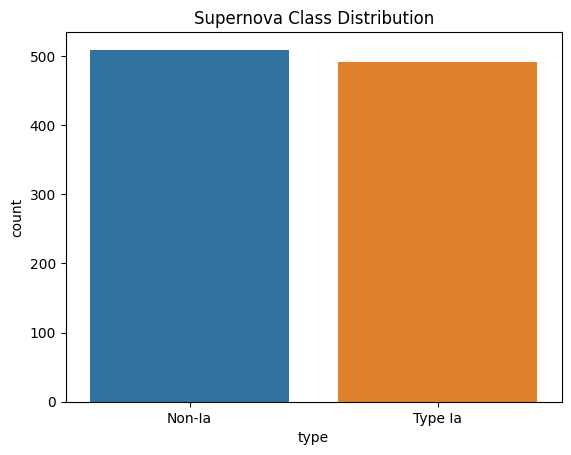

In [110]:
# Features: peak magnitude (u,g,r), decline rate (dm15), color (g-r)
X = np.random.randn(n_samples, 5)  # 5 features
X[:, 0] += 2.0  # Type Ia are typically brighter in 'u'
X[:, 3] += 0.5  # Type Ia have faster decline rates (dm15)

# Labels: 1 = Type Ia, 0 = Non-Ia (Type II, Ibc, etc.)
y = np.where(X[:, 0] + X[:, 3] > 2.5, 1, 0)  # Simple decision rule for synthetic data
# Convert to DataFrame for visualization
df = pd.DataFrame(X, columns=['peak_u', 'peak_g', 'peak_r', 'dm15', 'color_g_r'])
df['type'] = y
df['type'] = df['type'].map({0: 'Non-Ia', 1: 'Type Ia'})
# Check class distribution
print(df['type'].value_counts())
sns.countplot(data=df, x='type')
plt.title("Supernova Class Distribution")
plt.show()

type
Type Ia     400
Type II     300
Type Ibc    200
Type IIn    100
Name: count, dtype: int64


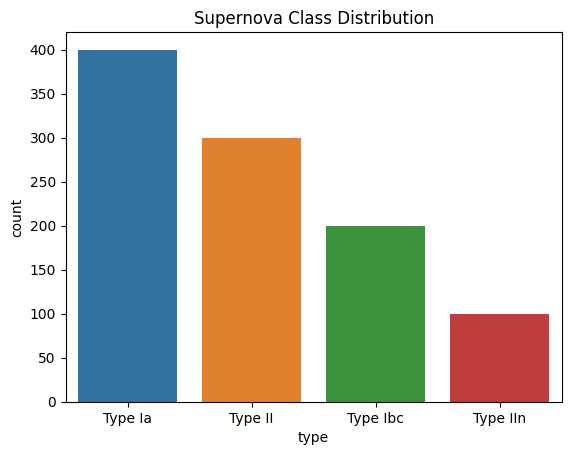

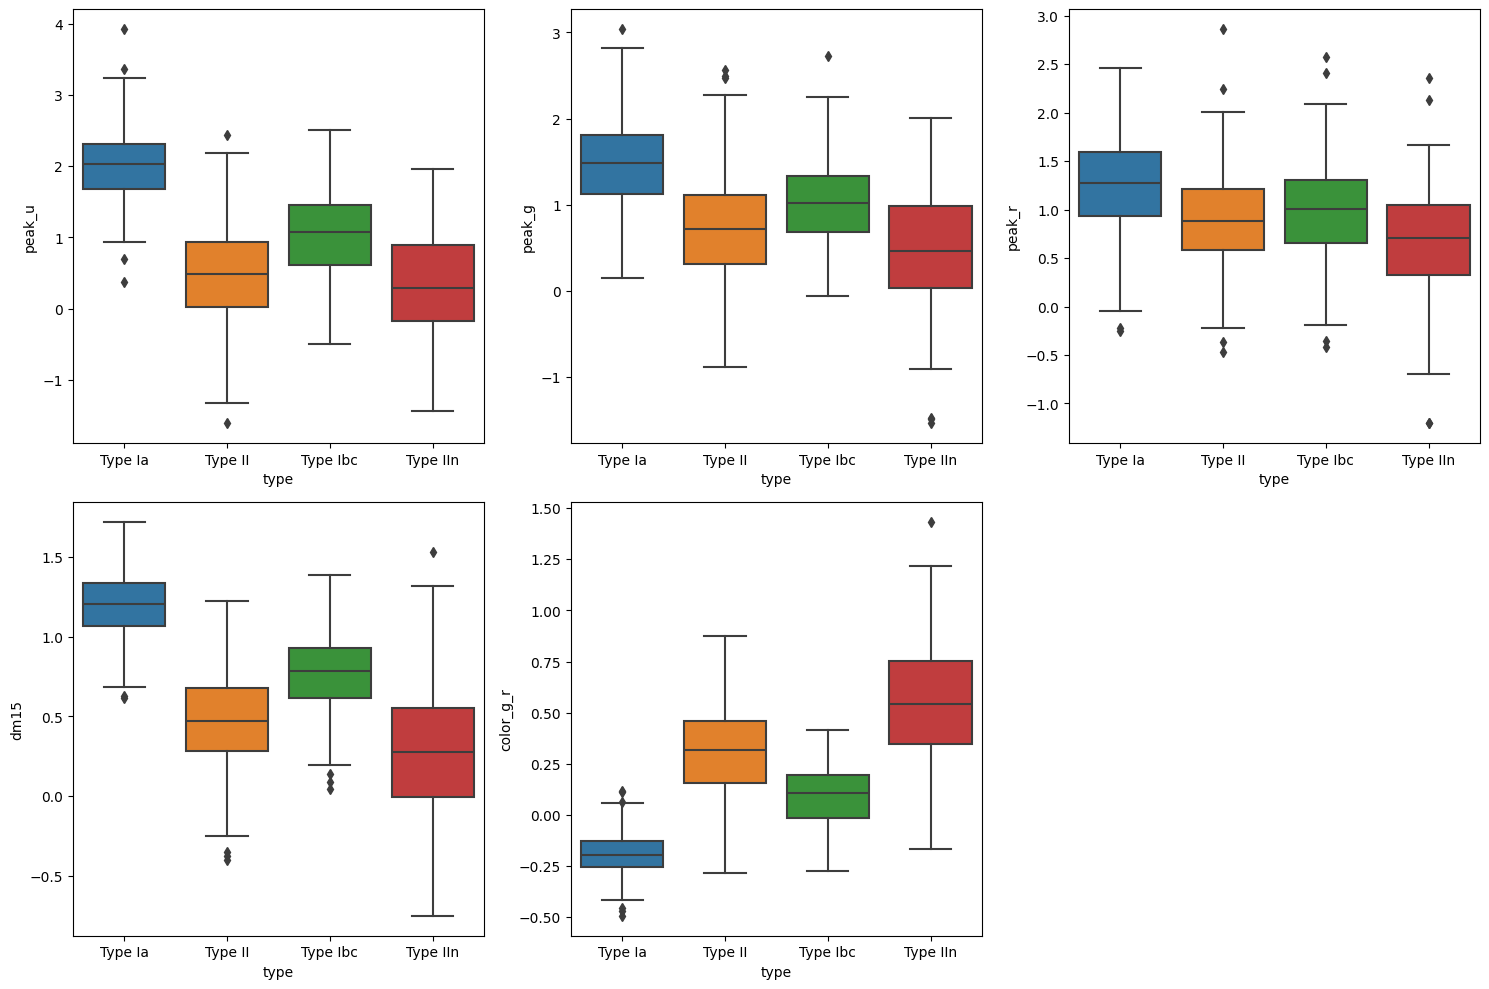

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

n_samples = 1000

# Features: peak magnitude (u,g,r), decline rate (dm15), color (g-r)
X = np.zeros((n_samples, 5))

# Class labels:
# 0 = Type Ia
# 1 = Type II
# 2 = Type Ibc
# 3 = Type IIn

# Generate data for each class with different distributions
n_ia = 400
n_ii = 300
n_ibc = 200
n_iin = 100

# Type Ia characteristics (bright in u, faster decline, bluer color)
X[:n_ia, 0] = np.random.normal(2.0, 0.5, n_ia)  # peak_u
X[:n_ia, 1] = np.random.normal(1.5, 0.5, n_ia)  # peak_g
X[:n_ia, 2] = np.random.normal(1.2, 0.5, n_ia)  # peak_r
X[:n_ia, 3] = np.random.normal(1.2, 0.2, n_ia)  # dm15
X[:n_ia, 4] = np.random.normal(-0.2, 0.1, n_ia)  # color_g_r

# Type II characteristics (fainter in u, slower decline, redder)
X[n_ia:n_ia+n_ii, 0] = np.random.normal(0.5, 0.7, n_ii)
X[n_ia:n_ia+n_ii, 1] = np.random.normal(0.7, 0.6, n_ii)
X[n_ia:n_ia+n_ii, 2] = np.random.normal(0.9, 0.5, n_ii)
X[n_ia:n_ia+n_ii, 3] = np.random.normal(0.5, 0.3, n_ii)
X[n_ia:n_ia+n_ii, 4] = np.random.normal(0.3, 0.2, n_ii)

# Type Ibc characteristics (intermediate properties)
X[n_ia+n_ii:n_ia+n_ii+n_ibc, 0] = np.random.normal(1.0, 0.6, n_ibc)
X[n_ia+n_ii:n_ia+n_ii+n_ibc, 1] = np.random.normal(1.1, 0.5, n_ibc)
X[n_ia+n_ii:n_ia+n_ii+n_ibc, 2] = np.random.normal(1.0, 0.5, n_ibc)
X[n_ia+n_ii:n_ia+n_ii+n_ibc, 3] = np.random.normal(0.8, 0.25, n_ibc)
X[n_ia+n_ii:n_ia+n_ii+n_ibc, 4] = np.random.normal(0.1, 0.15, n_ibc)

# Type IIn characteristics (very slow decline, red)
X[n_ia+n_ii+n_ibc:, 0] = np.random.normal(0.3, 0.8, n_iin)
X[n_ia+n_ii+n_ibc:, 1] = np.random.normal(0.5, 0.7, n_iin)
X[n_ia+n_ii+n_ibc:, 2] = np.random.normal(0.7, 0.6, n_iin)
X[n_ia+n_ii+n_ibc:, 3] = np.random.normal(0.3, 0.4, n_iin)
X[n_ia+n_ii+n_ibc:, 4] = np.random.normal(0.5, 0.3, n_iin)

# Create labels
y = np.concatenate([
    np.zeros(n_ia),  # Type Ia
    np.ones(n_ii),   # Type II
    2 * np.ones(n_ibc),  # Type Ibc
    3 * np.ones(n_iin)   # Type IIn
])

# Convert to DataFrame for visualization
df = pd.DataFrame(X, columns=['peak_u', 'peak_g', 'peak_r', 'dm15', 'color_g_r'])
df['type'] = y
df['type'] = df['type'].map({
    0: 'Type Ia',
    1: 'Type II',
    2: 'Type Ibc',
    3: 'Type IIn'
})

# Check class distribution
print(df['type'].value_counts())
sns.countplot(data=df, x='type', order=['Type Ia', 'Type II', 'Type Ibc', 'Type IIn'])
plt.title("Supernova Class Distribution")
plt.show()

# Visualize feature distributions by type
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.boxplot(data=df, x='type', y='peak_u', order=['Type Ia', 'Type II', 'Type Ibc', 'Type IIn'], ax=axes[0,0])
sns.boxplot(data=df, x='type', y='peak_g', order=['Type Ia', 'Type II', 'Type Ibc', 'Type IIn'], ax=axes[0,1])
sns.boxplot(data=df, x='type', y='peak_r', order=['Type Ia', 'Type II', 'Type Ibc', 'Type IIn'], ax=axes[0,2])
sns.boxplot(data=df, x='type', y='dm15', order=['Type Ia', 'Type II', 'Type Ibc', 'Type IIn'], ax=axes[1,0])
sns.boxplot(data=df, x='type', y='color_g_r', order=['Type Ia', 'Type II', 'Type Ibc', 'Type IIn'], ax=axes[1,1])
fig.delaxes(axes[1,2])
plt.tight_layout()
plt.show()

# 2. Preprocessing
## 2.1 Train-Test Split

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
# 2.2 Feature Scaling
# SVM is sensitive to feature scales, so we standardize the data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train shape: (800, 5), Test shape: (200, 5)


### 3. SVM Model Training
#### 3.1 Baseline SVM (Linear Kernel)

In [116]:
svm_linear = SVC(kernel='linear', C=1.0, random_state=42)
svm_linear.fit(X_train_scaled, y_train)
# Predictions
y_pred_linear = svm_linear.predict(X_test_scaled)

In [123]:
### Evaluate
print(classification_report(y_test, y_pred_linear, target_names=['Non-Ia', 'Type Ia']))
print(f"Accuracy: {accuracy_score(y_test, y_pred_linear):.3f}")
# Output:
# Precision, recall, F1-score for each class.
# Accuracy (~85-90% for synthetic data).
# 3.2 SVM with RBF Kernel (Non-linear Decision Boundary)

              precision    recall  f1-score   support

      Non-Ia       0.99      1.00      1.00       102
     Type Ia       1.00      0.99      0.99        98

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200

Accuracy: 0.995


In [119]:
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_rbf.fit(X_train_scaled, y_train)
y_pred_rbf = svm_rbf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_rbf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rbf):.3f}")

# Output:
# Potentially better performance if data is non-linear.
# 4. Hyperparameter Tuning (Grid Search)
# Optimize C (regularization) and gamma (RBF kernel influence).

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       102
           1       0.98      0.98      0.98        98

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200

Accuracy: 0.980


In [125]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.3f}")

# Best model
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)
print(classification_report(y_test, y_pred_best))

# Output:
# Best hyperparameters (e.g., C=10, gamma=0.1).
# Improved test accuracy (~90-95%).
# 5. Evaluation Metrics
# 5.1 Confusion Matrix

Best parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Best CV accuracy: 0.969
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       102
           1       0.96      0.97      0.96        98

    accuracy                           0.96       200
   macro avg       0.96      0.97      0.96       200
weighted avg       0.97      0.96      0.97       200



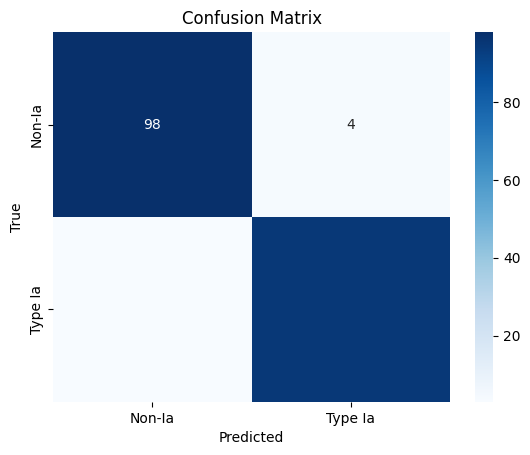

In [127]:
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Ia', 'Type Ia'], yticklabels=['Non-Ia', 'Type Ia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

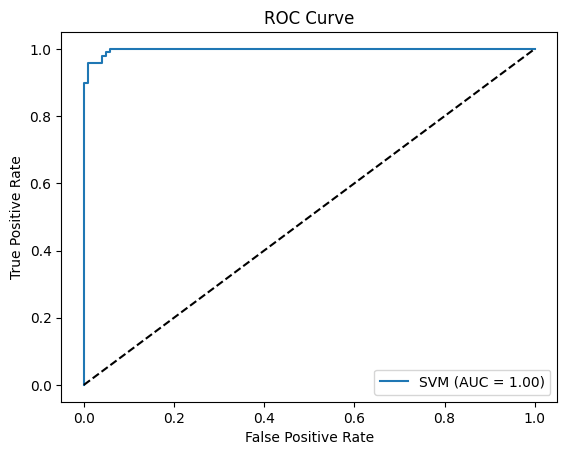

In [129]:
# 5.2 ROC Curve (for Probability Estimates)

y_probs = best_svm.decision_function(X_test_scaled)  # Not probabilities, but scores
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Output:
# AUC score (e.g., 0.95) indicating strong separability.

### 6. Feature Importance (Linear SVM Coefficients)

In [136]:
if best_svm.kernel == 'linear':
    coef_df = pd.DataFrame({'feature': df.columns[:-1], 'weight': best_svm.coef_[0]})
    coef_df = coef_df.sort_values('weight', ascending=False)
    sns.barplot(data=coef_df, x='weight', y='feature')
    plt.title('Feature Importance (Linear SVM)')
    3plt.show()